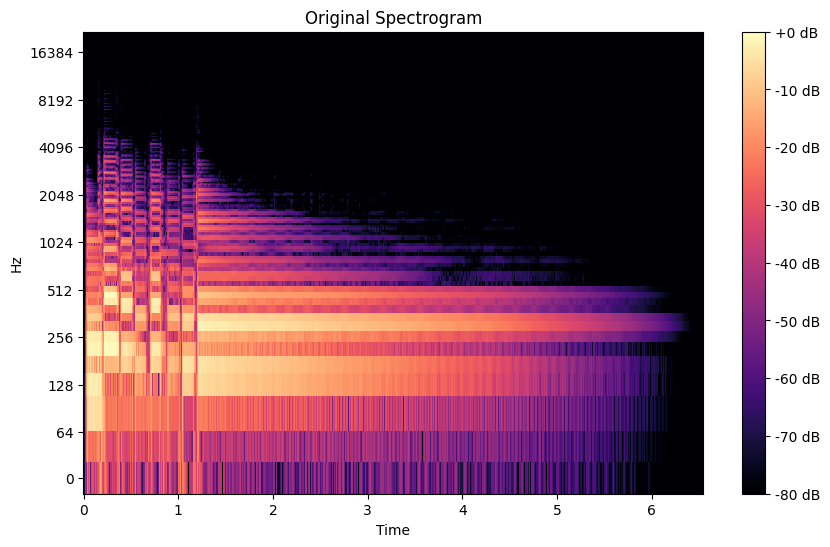

In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy.signal as sig
from scipy.io import wavfile

# Чтение звукового файла
input_path = 'input/sample.wav'
sr, signal = wavfile.read(input_path)
signal = signal / np.max(np.abs(signal))  # Нормализация сигнала

# Построение спектрограммы
def plot_spectrogram(signal, sr, window_size, hop_length, title):
    S = librosa.stft(signal, n_fft=window_size, hop_length=hop_length, window='hann')
    S_DB = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()
    return S_DB

window_size = 1024
hop_length = 256

# Построение исходной спектрограммы
S_DB_original = plot_spectrogram(signal, sr, window_size, hop_length, 'Original Spectrogram')




In [41]:
# Удаление шума и нормализация
def remove_noise(signal, sr, window_size, hop_length):
    S = librosa.stft(signal, n_fft=window_size, hop_length=hop_length, window='hann')
    S_DB = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    
    # Применение фильтра Савицкого-Голея
    S_DB_savgol = sig.savgol_filter(S_DB, 21, 5, axis=1)
    
    # Восстановление звуковой дорожки
    D_savgol = librosa.db_to_amplitude(S_DB_savgol)
    y_savgol = librosa.istft(D_savgol, hop_length=hop_length)
    
    # Нормализация амплитуды
    y_savgol = y_savgol / np.max(np.abs(y_savgol))
    
    # Сохранение восстановленного аудио
    wavfile.write('savgol_filtered.wav', sr, (y_savgol * 32767).astype(np.int16))
    
    return S_DB, S_DB_savgol

# Удаление шума
S_DB, S_DB_savgol = remove_noise(signal, sr, window_size, hop_length)





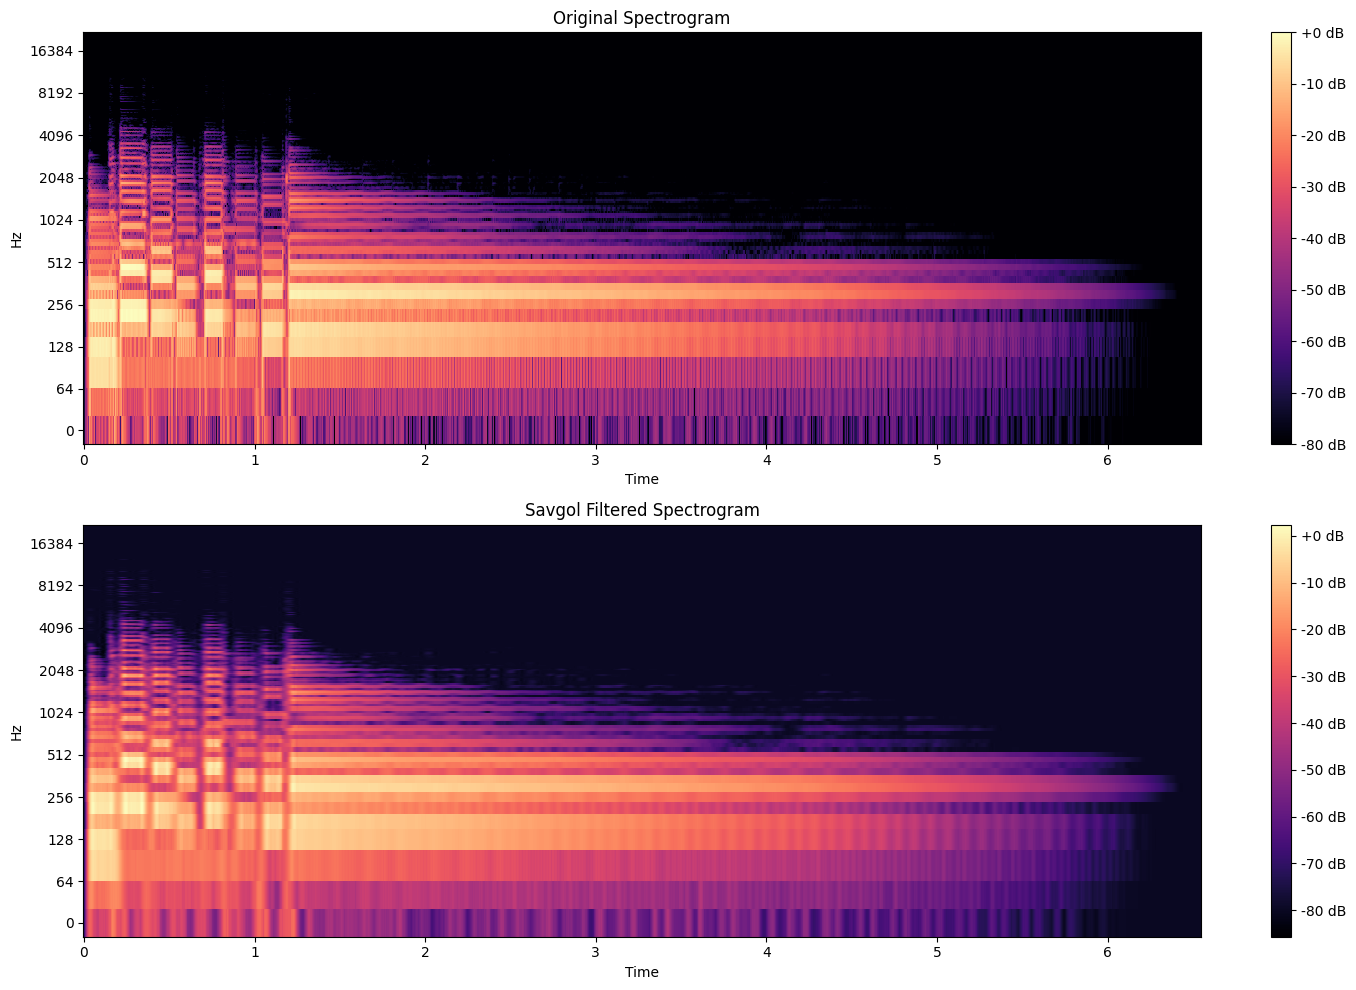

In [42]:
# Визуализация спектрограммы до и после удаления шума
def plot_filtered_spectrogram(S_DB, S_DB_savgol, sr, hop_length):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Original Spectrogram')
    
    plt.subplot(2, 1, 2)
    librosa.display.specshow(S_DB_savgol, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Savgol Filtered Spectrogram')
    
    plt.tight_layout()
    plt.show()

# Визуализация
plot_filtered_spectrogram(S_DB, S_DB_savgol, sr, hop_length)


Times with highest energy: [0.04643991 0.17414966 0.22058957 0.30185941 0.40634921 0.49922902
 0.59210884 0.71981859 0.78947846 0.90557823 1.05650794 1.09714286
 1.21904762 1.29451247 1.39319728 1.48027211 1.57895692 1.67764172
 1.77632653 1.87501134 1.97369615 2.07238095 2.21170068 2.26975057
 2.36843537 2.46712018 2.60643991 2.67029478 2.80380952 2.86185941
 2.99537415 3.09986395 3.19854875 3.28562358 3.39011338 3.48879819
 3.58748299 3.68036281 3.79646259 3.88353741 3.98222222 4.06929705
 4.17378685 4.27247166 4.35954649 4.45823129 4.56272109 4.64979592
 4.74848073 4.85297052 4.95165533 5.03873016 5.14321995 5.24190476
 5.34058957 5.4276644  5.5321542  5.630839   5.7353288  5.82240363
 5.92108844 6.01977324 6.11845805 6.21714286 6.31582766 6.41451247
 6.51319728]


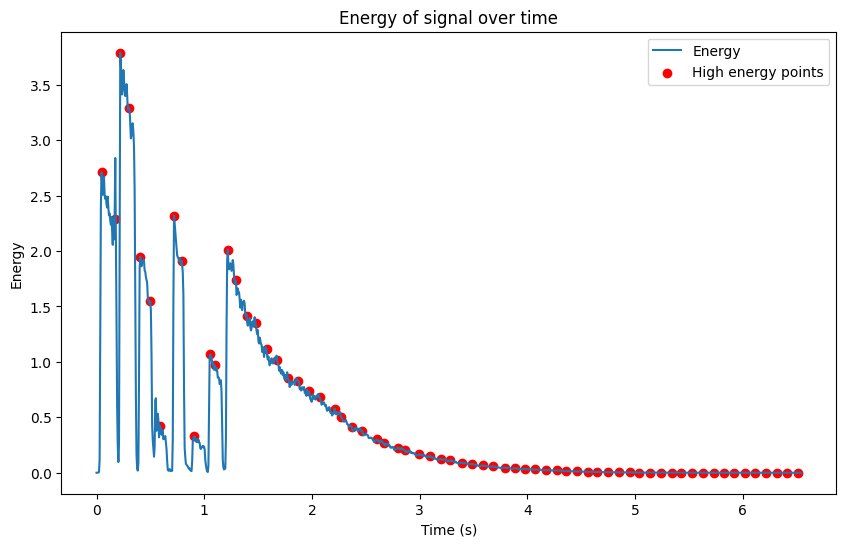

In [43]:
# Нахождение моментов времени с наибольшей энергией
def find_high_energy_segments(S_DB, sr, hop_length, time_window=0.1, freq_window=50):
    S = librosa.db_to_amplitude(S_DB)
    energy = np.sum(S**2, axis=0)
    
    step = int(time_window * sr / hop_length)
    max_energy_indices = []

    for i in range(0, len(energy), step):
        segment = energy[i:i + step]
        max_index = i + np.argmax(segment)
        max_energy_indices.append(max_index)

    times = librosa.frames_to_time(max_energy_indices, sr=sr, hop_length=hop_length)
    return times

high_energy_times = find_high_energy_segments(S_DB, sr, hop_length)
print("Times with highest energy:", high_energy_times)

# Визуализация моментов времени с наибольшей энергией
def plot_energy_peaks(S_DB, sr, hop_length, high_energy_times):
    S = librosa.db_to_amplitude(S_DB)
    energy = np.sum(S**2, axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(librosa.frames_to_time(range(len(energy)), sr=sr, hop_length=hop_length), energy, label='Energy')
    plt.scatter(high_energy_times, energy[[librosa.time_to_frames(t, sr=sr, hop_length=hop_length) for t in high_energy_times]], color='red', label='High energy points')
    plt.xlabel('Time (s)')
    plt.ylabel('Energy')
    plt.title('Energy of signal over time')
    plt.legend()
    plt.show()

plot_energy_peaks(S_DB, sr, hop_length, high_energy_times)
